# Проект увеличения покупательской активности клиентов для интернет-магазина «В один клик».

**Описание проекта:**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Цель проекта:**

1.	Разработать модель, которая предскажет вероятность снижения покупательской активности.
2.	Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность. 

**Ход выполнения проекта:**

1. Загрузка данных.
2. Предобработка данных.
3. Исследовательский анализ.
4. Объединение данных.
5. Корреляционный анализ.
6. Разработка модели, которая предскажет вероятность снижения покупательской активности.
 - Подготовка данных для МО.
 - Обучение моделей.
 - Выбор лучшей модели.
7. Анализ важности признаков.
8. Сегментация покупателей и предложения.
9. Общий вывод.

**Описание источников данных:**

1. market_file.csv - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. market_money.csv - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
3. market_time.csv - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
4. money.csv - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [1]:
!pip install -q --upgrade numpy
!pip install -q --upgrade scipy 
!pip install -q --upgrade numba 

!pip install -q --upgrade pandas
!pip install -q --upgrade pyarrow
!pip install -q --upgrade scikit-learn
!pip install -q --upgrade matplotlib
!pip install -q --upgrade seaborn

!pip install -q phik
!pip install -q optuna
!pip install -q optuna-integration
!pip install -q shap
!pip install -q lime

In [2]:
# Импорт библиотек
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier as LGBMC

from sklearn.inspection import permutation_importance
import shap
from lime import lime_tabular

from optuna.integration import OptunaSearchCV
from optuna.samplers import TPESampler
from optuna import distributions, Trial, create_study

In [3]:
RANDOM_STATE = 42

## Загрузка данных

In [4]:
if os.path.exists('/datasets/market_file.csv'):
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
    print('Загрузка завершена')
#elif os.path.exists(pth2):
#    df1 = pd.read_csv(pth2)
else:
    print('ОШИБКА: Файлы не найдены!')

Загрузка завершена


In [5]:
# Вспомогательная функция
def inf(df):    
    display(df.head())
    print()
    print('*******************************')
    print()
    df.info()

In [6]:
# Изучим имеющиеся данные

raw_data = [market_file, market_money, market_time, money]

for i in raw_data:
    inf(i)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



*******************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



*******************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



*******************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



*******************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [7]:
# Для удобства исправим некоторые имена колонок

#market_file.columns
market_file.columns = ['id', 'Активность', 'Тип', 'Сообщения',
       'Маркет_6_мес', 'Маркет_тек_мес', 'Длительн_рег',
       'Акционные', 'Популярная_кат',
       'Средн_просмотр',
       'Неоплаченно', 'Ошибки',
       'Страницы']
market_file.head(2)

,id,Активность,Тип,Сообщения,Маркет_6_мес,Маркет_тек_мес,Длительн_рег,Акционные,Популярная_кат,Средн_просмотр,Неоплаченно,Ошибки,Страницы
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5


**Выводы по загрузке данных:**

Данные загружены. Столбцы и записи соответствуют описанию. Всего 1300 клиентов.

Количество строк в датасетах разное - перед объединением следует решить этот момент.

Явные опечатки - в первом и третьем датасетах.

Типы данных - соответствуют.

Данные о периодах представлены в одном столбце (датасет 2 и 3) - предстоит создать новые столбцы по кол-ву периодов.

Хорошая новость: в данных пропусков нет совсем.

Названия столбцов для удобства заменены в 1м датасете.

## Предобработка данных

In [8]:
# Создадим копии перед изменениями
df1 = market_file.copy()
df2 = market_money.copy()
df3 = market_time.copy()
df4 = money.copy()
dfs = [df1, df2, df3, df4]

### Пропуски

In [9]:
# Проверим на пропуски
for i in dfs:
    display(i.isna().sum())

id                0
Активность        0
Тип               0
Сообщения         0
Маркет_6_мес      0
Маркет_тек_мес    0
Длительн_рег      0
Акционные         0
Популярная_кат    0
Средн_просмотр    0
Неоплаченно       0
Ошибки            0
Страницы          0
dtype: int64

id         0
Период     0
Выручка    0
dtype: int64

id        0
Период    0
минут     0
dtype: int64

id         0
Прибыль    0
dtype: int64

Пропусков нет.

### Явные дубликаты

In [10]:
# Проверим явные дубликаты
for i in dfs:
    display(i.duplicated().sum())

np.int64(0)

np.int64(0)

np.int64(0)

np.int64(0)

Явных дубликатов нет.

### Категориальные столбцы

In [11]:
# Изучим категории

def cat_check(df, columns):
    for i in columns:
        display(i, df[i].unique())

cat_cols1 = ['Активность', 'Тип', 'Сообщения', 'Популярная_кат']
cat_cols2 = ['Период']

cat_check(df1, cat_cols1)

'Активность'

array(['Снизилась', 'Прежний уровень'], dtype=object)

'Тип'

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

'Сообщения'

array(['да', 'нет'], dtype=object)

'Популярная_кат'

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Есть ошибки в столбце "Тип" - исправим их.

In [12]:
# Исправим значения
df1['Тип'] = df1['Тип'].str.replace('стандартт', 'стандарт')
cat_check(df1, ['Тип'])

'Тип'

array(['премиум', 'стандарт'], dtype=object)

In [13]:
cat_check(df2, cat_cols2)

'Период'

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [14]:
cat_check(df3, cat_cols2)

'Период'

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [15]:
# исправим период
df3['Период'] = df3['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
df3['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

### Числовые столбцы

In [16]:
df1.nunique()

id                1300
Активность           2
Тип                  2
Сообщения            2
Маркет_6_мес        41
Маркет_тек_мес       3
Длительн_рег       658
Акционные           42
Популярная_кат       6
Средн_просмотр       6
Неоплаченно         11
Ошибки              10
Страницы            20
dtype: int64

In [17]:
# Дубли пользователей
df1['id'].duplicated().sum()

np.int64(0)

In [18]:
#df1.columns

In [19]:
def num_check(df, columns):
    for i in columns:
        display(i, df[i].unique())

num_cols1 = ['Маркет_6_мес', 'Маркет_тек_мес', 'Длительн_рег', 'Акционные',
             'Средн_просмотр', 'Неоплаченно', 'Ошибки', 'Страницы']

#num_check(df1, num_cols1)

In [20]:
df2.nunique()

id         1300
Период        3
Выручка    2776
dtype: int64

In [21]:
df3.nunique()

id        1300
Период       2
минут       20
dtype: int64

In [22]:
df3['минут'].unique()

array([14, 13, 10, 12,  8, 11,  6,  7,  9,  5, 15,  4, 16, 17, 19, 18, 22,
       20, 21, 23])

In [23]:
df4.nunique()

id         1300
Прибыль     400
dtype: int64

### Выводы по предобработке данных

Пропусков данных - не выявленно.

Явных дублей - не выявленно.

Типы данных - соответствуют.

Категориальные признаки - исправлены опечатки (колонки Период и Тип).

Числовые признаки - проблем не выявленно.

Количество уникальных значений (пользователей) по таблицам совпадает - объединение должно пройти без проблем.

Названия столбцов - сохранены кириллическими.

Кодирование признаков - проведем в конвейере для модели.

## Исследовательский анализ

### Анализ данных

Активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

Text(0.5, 1.0, 'Доля наблюдений по целевой переменной')

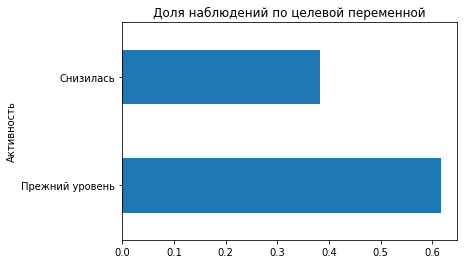

In [24]:
# Дисбаланс целевой переменной

display(df1['Активность'].value_counts())

df1['Активность'].value_counts(normalize=True).plot(kind='barh')
plt.title('Доля наблюдений по целевой переменной')

Присутствует дисбаланс целевой переменной. Целевая переменная - бинарная.

Примем это во внимание при подготовке модели и выборе метрики.

In [25]:
# Описательная статистика

for i in dfs:
    display(i.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительн_рег,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средн_просмотр,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченно,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибки,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страницы,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


Аномальных значений - не наблюдается.

Минимумы и максимумы - ок.

Среднее и ст.отклонение - сильный разброс не наблюдается.

Признаков с низкой дисперсией - не наблюдается.

Возможны выбросы по выручке - проверим на графиках.

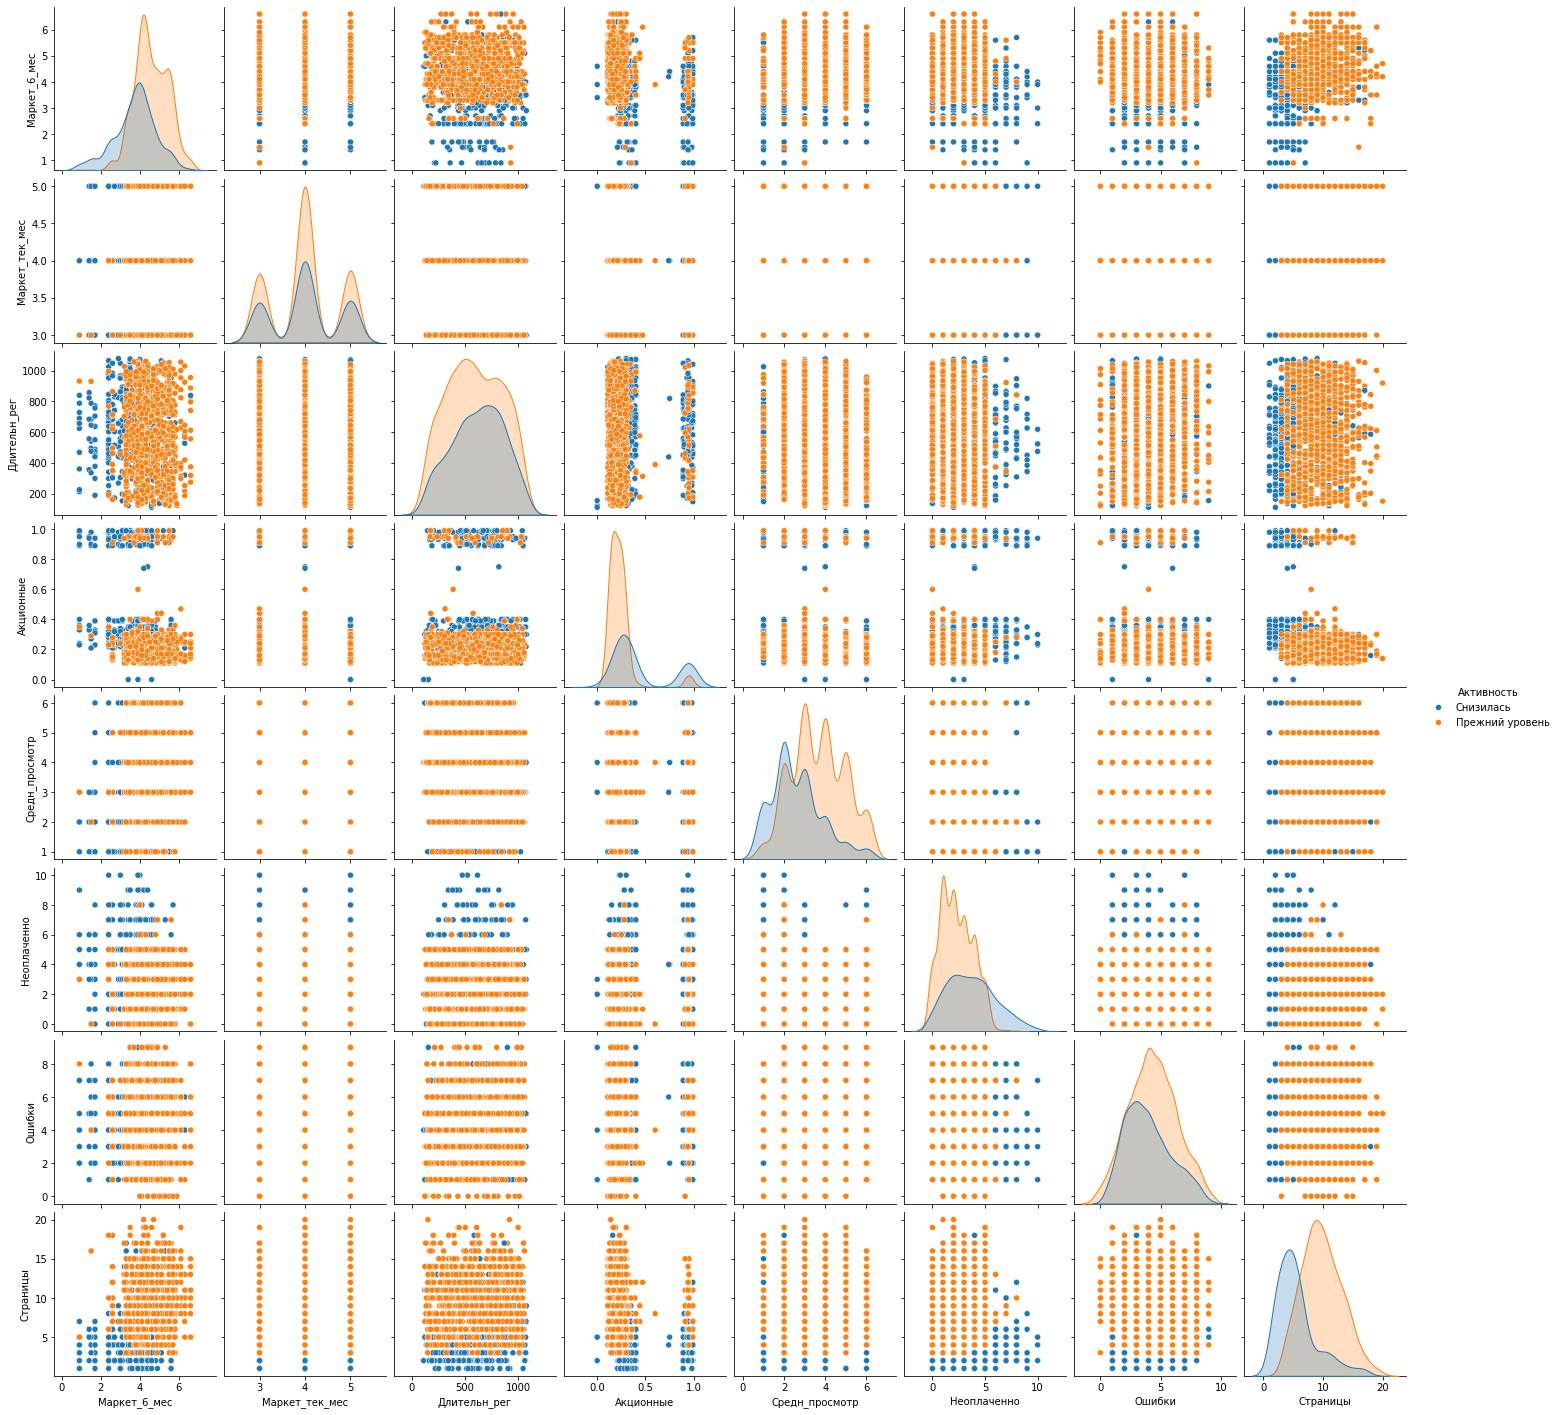

In [26]:
# Диаграммы рассеяния

num_cols1_ = num_cols1 + ['Активность']
sns.pairplot(df1[num_cols1_], hue='Активность')

Визуально, явная классификация целевой переменной просматривается с признаками: 
 - Страницы (мало страниц - снижается активность)
 - Неоплачено (много неоплат - снижается активность)
 - Средний просмотр категорий (мало - снижается)
 - Маркетинг_6мес (мало - снижается)

Можно выделить четкие категории:
 - Акционные (халявщики и норм)
 - Маркетинг_тек_мес (3 - 4 - 5)

Остальные признаки имеют колоколообразное распределение.

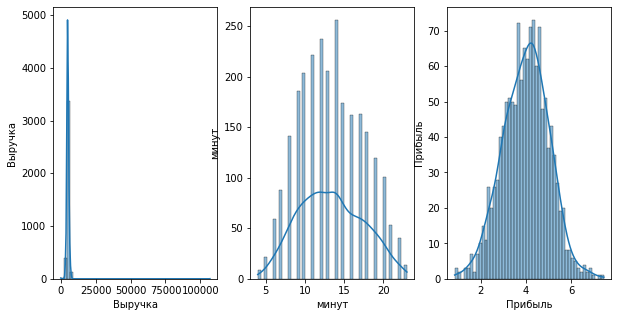

In [27]:
# Рассмотрим числовые признаки в остальных датасетах

names = ['Выручка','минут','Прибыль']
dfs_ = [df2,df3,df4]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
for idx, df in enumerate(dfs_):
    sns.histplot(data=df, x=names[idx], bins=50, kde=True, ax=axes[idx]);
    axes[idx].set_ylabel(names[idx]) 

Выручка - явно имеет выбросы.
Остальные призаки - распределены близко к нормальному.

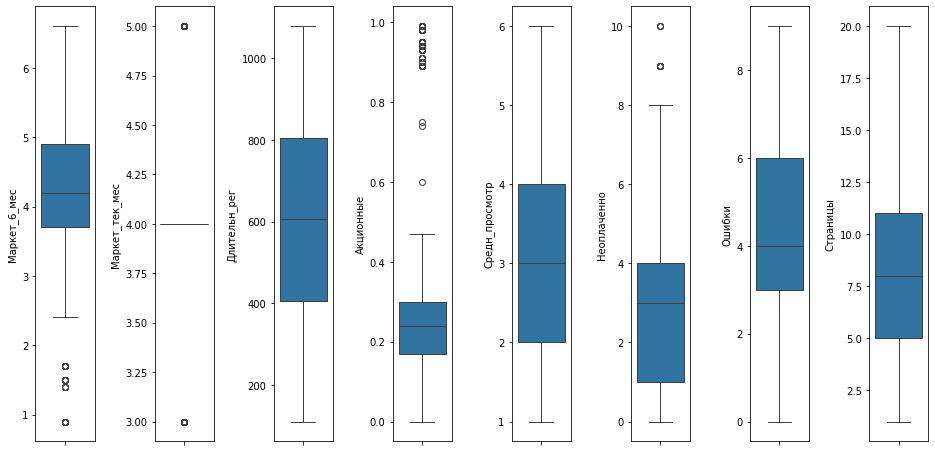

In [28]:
# Боксплоты: Определимся с выбросами в числовых данных

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(16, 8))
for idx, feat in enumerate(num_cols1):
    sns.boxplot(y=feat, data=df1, ax=axes[idx])       
    axes[idx].set_ylabel(num_cols1[idx])
    fig.subplots_adjust(wspace=1)

Наблюдаются выбросы в признаках: Маркетинг_6мес, Акционные, Неоплачено.

Пока оставим данные без изменений.

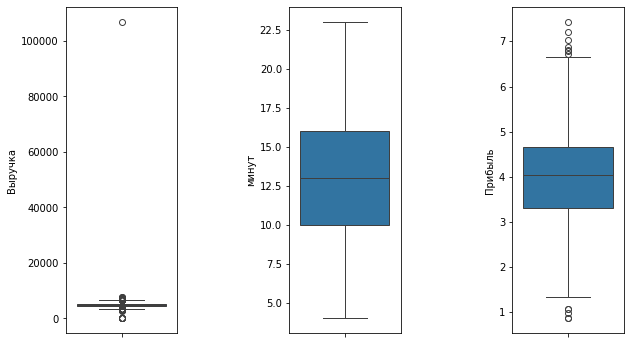

In [29]:
names = ['Выручка','минут','Прибыль']
dfs_ = [df2,df3,df4]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
for idx, df in enumerate(dfs_):
    sns.boxplot(data=df, y=names[idx], ax=axes[idx])
    axes[idx].set_ylabel(names[idx])           
    fig.subplots_adjust(wspace=1)

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


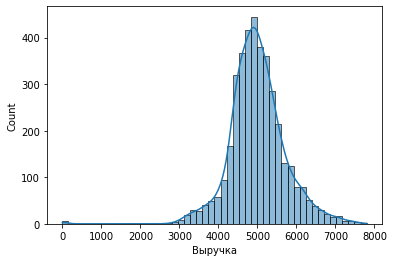

In [30]:
# Изучим выбросы по Выручке

display(df2[df2['Выручка']>10000])

sns.histplot(data=df2[df2['Выручка']<10000], x='Выручка', bins=50, kde=True);

Всего 1 наблюдение является выбросом.

Text(0, 0.5, 'Кол-во')

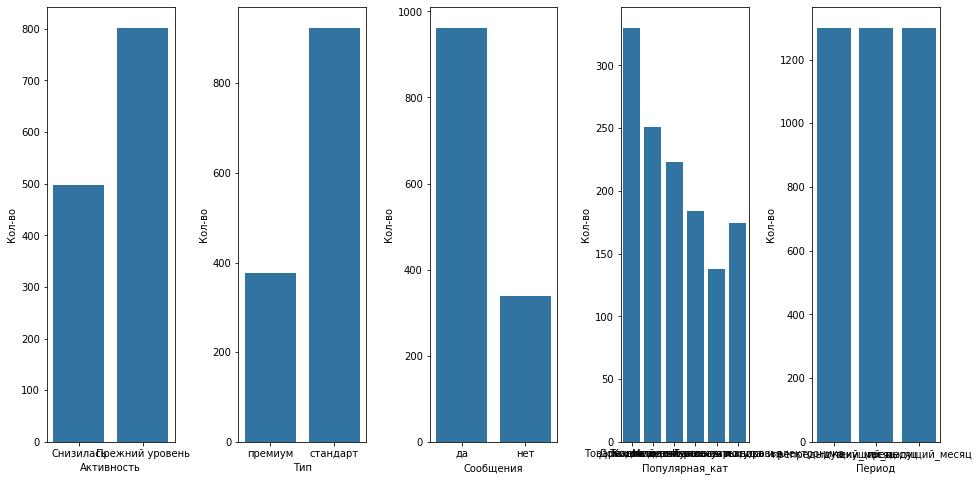

In [31]:
# Категориальные данные

# Столбиковые диаграммы по категориям
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 8))
for idx, feat in enumerate(cat_cols1):    
    sns.countplot(data=df1, x=feat, ax=axes[idx])
    axes[idx].set_xlabel(feat)
    axes[idx].set_ylabel("Кол-во")
    fig.subplots_adjust(wspace=0.5)
sns.countplot(data=df2, x='Период', ax=axes[4])
axes[4].set_xlabel('Период')
axes[4].set_ylabel("Кол-во")

В данных присутствует дисбаланс - будем применять стратификацию при подготовке данных для МО.

### Отбор активных клиентов

In [32]:
# Отбор клиентов с активностью не менее 3х мес.

df2_ = df2.pivot(index='id', columns='Период', values='Выручка')
df2_ = df2_.reset_index()
df2_.columns = ['id', 'выручка_2мес', 'выручка_3мес', 'выручка_1мес']
df2_cut = df2_.query('выручка_2мес>0 and выручка_3мес>0 and выручка_1мес>0 and выручка_1мес<10000')
display(df2_cut.head(3))
df2_cut.shape

,id,выручка_2мес,выручка_3мес,выручка_1мес
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4


(1296, 4)

Отбор активных клиентов (минус выброс) сокращает датасет всего на 4 наблюдения.

Проведем данный отбор после объединения таблиц.

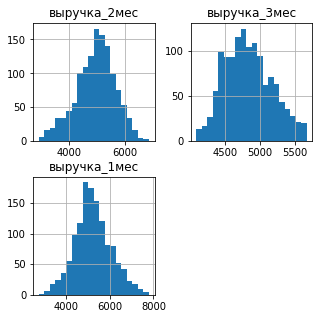

In [33]:
# Гистограммы по выручке

df2_cut.drop('id',axis=1).hist(bins=20, figsize=(5,5))
plt.show()

Распределение выручки по месяцам - близкое к нормальному.

### **Выводы по исследовательскому анализу данных:**

Выявлен дисбаланс и целевой переменной, и признаков - будем применять стратификацию. Причины дисбаланса - скорее естественные.

Выброс по Выручке: 1 шт. - некоторые модели могут быть чувствительными к выбросам - удалим его перед обучением.

Аномальных значений - не наблюдается.

Визуально, явная зависимость целевой переменной просматривается с признаками: 
 - Страницы (мало страниц - снижается активность)
 - Неоплачено (много неоплат - снижается активность)
 - Средний просмотр категорий (мало - снижается)
 - Маркетинг_6мес (мало - снижается)

Можно выделить четкие категории:
 - Акционные (халявщики и норм)
 - Маркетинг_тек_мес (3 - 4 - 5)

Остальные признаки имеют колоколообразное распределение.

Отбор активных клиентов определил 1296чел. (из 1300) для дальнейшего обучения моделей.

Дополнительно рассмотрим связь переменных на этапе корреляционного анализа.

## Объединение данных

In [34]:
for i in dfs:
    print(i.shape)

(1300, 13)
(3900, 3)
(2600, 3)
(1300, 2)


In [35]:
display(df2_.shape)
df2_.head(2)

(1300, 4)

,id,выручка_2мес,выручка_3мес,выручка_1мес
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6


In [36]:
# Приведем строки в столбцы для df3

df3_ = df3.pivot(index='id', columns='Период', values='минут')
df3_ = df3_.reset_index()
df3_.columns = ['id', 'время_2мес', 'время_1мес']
display(df3_.shape)
df3_.head(2)

(1300, 3)

,id,время_2мес,время_1мес
0,215348,13,14
1,215349,12,10


In [37]:
# Последовательно объедими таблицы

df_all = df1.merge(df2_, on='id', how='outer')
df_all = df_all.merge(df3_, on='id', how='outer')
display(df.shape)
df_all.head(3)

(1300, 2)

,id,Активность,Тип,Сообщения,Маркет_6_мес,Маркет_тек_мес,Длительн_рег,Акционные,Популярная_кат,Средн_просмотр,Неоплаченно,Ошибки,Страницы,выручка_2мес,выручка_3мес,выручка_1мес,время_2мес,время_1мес
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13


In [38]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1300 non-null   int64  
 1   Активность      1300 non-null   object 
 2   Тип             1300 non-null   object 
 3   Сообщения       1300 non-null   object 
 4   Маркет_6_мес    1300 non-null   float64
 5   Маркет_тек_мес  1300 non-null   int64  
 6   Длительн_рег    1300 non-null   int64  
 7   Акционные       1300 non-null   float64
 8   Популярная_кат  1300 non-null   object 
 9   Средн_просмотр  1300 non-null   int64  
 10  Неоплаченно     1300 non-null   int64  
 11  Ошибки          1300 non-null   int64  
 12  Страницы        1300 non-null   int64  
 13  выручка_2мес    1300 non-null   float64
 14  выручка_3мес    1300 non-null   float64
 15  выручка_1мес    1300 non-null   float64
 16  время_2мес      1300 non-null   int64  
 17  время_1мес      1300 non-null   i

**Выводы:**

Данные сведены в одну таблицу.

Группировка периодов по выручке и времени - преобразована в столбцы.

Новая форма имеет 1300 строк и 18 столбцов.

## Корреляционный анализ

In [39]:
# Отберем активных пользователей и устраним выброс в итоговом датасете

display(df_all.shape)
df = df_all.query('выручка_2мес>0 and выручка_3мес>0 and выручка_1мес>0 and выручка_1мес<10000')
df = df.set_index('id')
df.shape

(1300, 18)

(1296, 17)

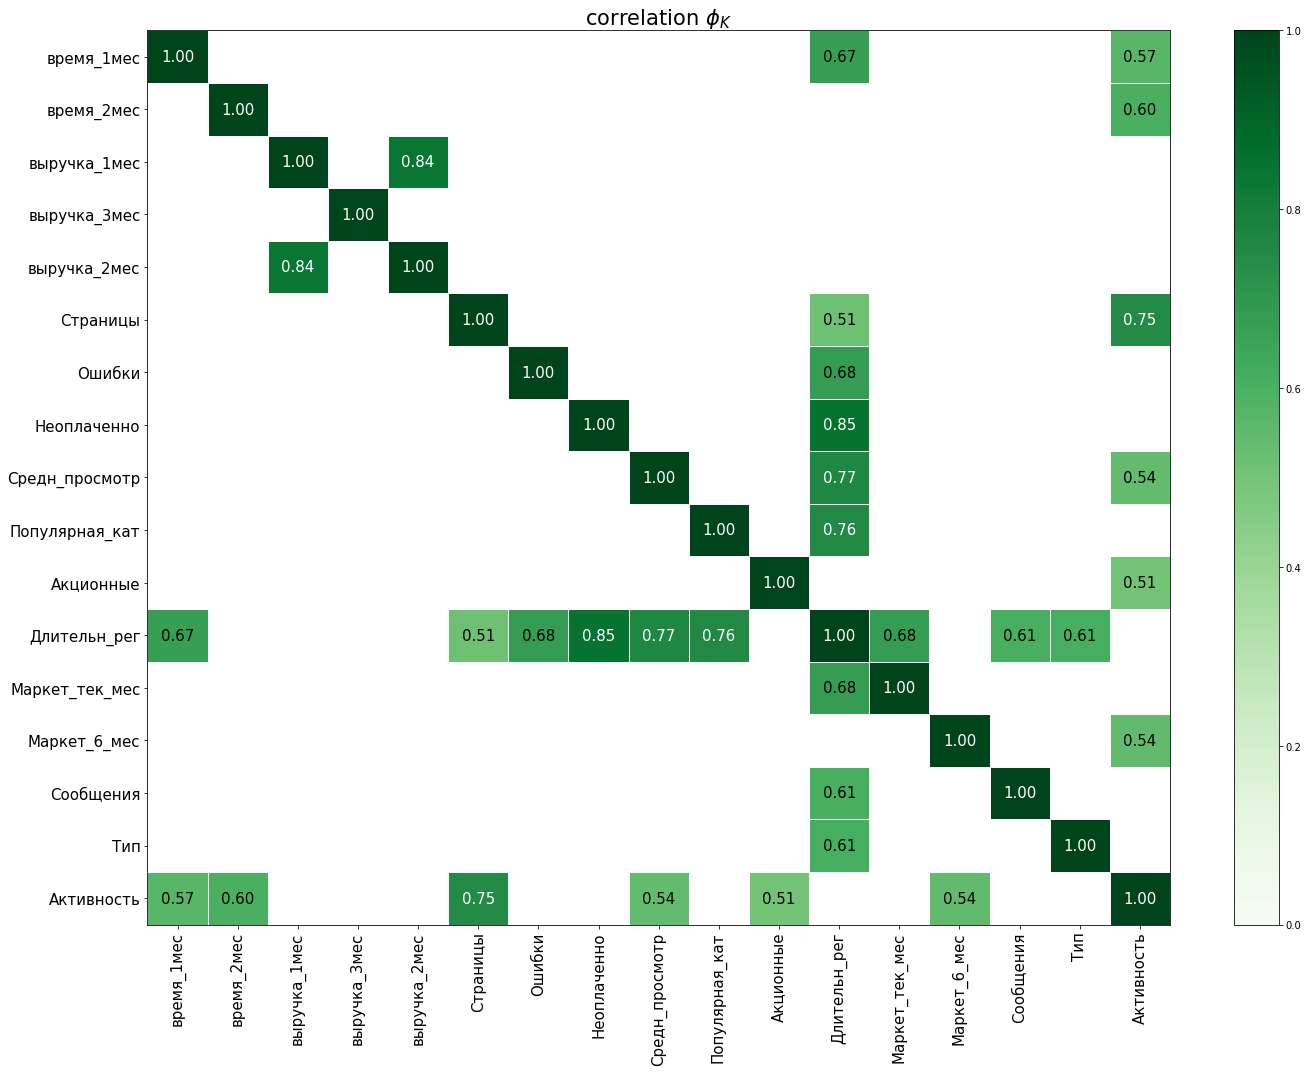

In [40]:
# Используем библиотеку phik

# Непрерывные переменные
interval_cols = ['Маркет_6_мес', 'Акционные', 'выручка_3мес', 'выручка_2мес', 'выручка_1мес']

m = phik_matrix(df, interval_cols=interval_cols)
plot_correlation_matrix(
    m[(m >= 0.5) | (m <= -0.5)].values,
    x_labels=m.columns,
    y_labels=m.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

<a id="corr"></a> 
**Выводы по корреляции:**

Зависимость с целевой переменной подтвердилась для признаков: Страницы, Средний просмотр, Маркетинг_6мес. Кроме того добавились: время_1мес, время 2 мес.
Зависимость Активности и Неоплачено - не проявилась.

Мультиколлениарность признаков (>0.9) - не установлена.

Утечка целевого признака (==1) - не выявлена.

Длительность с момента регистрации - коррелирует с половиной остальных признаков.

Выручка по месяцам (2 и 3) коррелирует между собой, но не дотягивает до 0.9.

## Разработка модели

### Подготовка данных для модели

По заданию требуется использовать разные типы кодирования - для этого подготовим наборы колонок (сделаем 3 варианта):
 - смешанный
 - все ohe
 - все ord

Варианты масштабирования числовых колонок - задействуем при подборе гиперпараметров.

In [41]:
df['Тип'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [42]:
# Объявим переменные

targ_col = 'Активность'

num_col = ['Маркет_6_мес', 'Маркет_тек_мес', 'Длительн_рег',
           'Акционные', 'Средн_просмотр', 'Неоплаченно',
           'Ошибки', 'Страницы', 'выручка_2мес', 'выручка_3мес',
           'выручка_1мес', 'время_2мес', 'время_1мес']

# вар 1
ohe_col_1 = ['Сообщения', 'Популярная_кат']

ord_col_1 = ['Тип']

ord_cat_1 = [['стандарт', 'премиум']]

display("вар_1:", len(num_col) + len(ohe_col_1) + len(ord_col_1) + len([targ_col]))

# вар 2
ohe_col_2 = ['Тип', 'Сообщения', 'Популярная_кат']

display("вар_2:", len(num_col) + len(ohe_col_2) + len([targ_col]))

'вар_1:'

17

'вар_2:'

17

In [43]:
# Функция для разделения данных - возвращает 4 датафрейма

def data_split(df, target, strat=True, TS=0.25, RS=42):
    print('Форма исходного датасета:', df.shape)
    print('***********************')
    
    X = df.drop(target, axis=1)
    y = df[target]
    print('Форма X, y:', X.shape, y.shape)
    print('***********************')
    
    if strat:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TS, random_state=RS, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TS, random_state=RS)
    
    print('Форма массивов после разделения:', X_train.shape,
          X_test.shape, y_train.shape, y_test.shape)
    print('***********************')
    
    return X_train, X_test, y_train, y_test

In [44]:
# Функция готовит целевую переменную

def target_prep(y_train, y_test):
    le = LabelEncoder()
    le.fit(np.ravel(y_train))
    y_train_enc = le.transform(np.ravel(y_train))
    y_test_enc = le.transform(np.ravel(y_test))
    
    print('Форма массивов:', y_train_enc.shape, y_test_enc.shape)
    
    return y_train_enc, y_test_enc, le

In [45]:
# Ф-ция создает конвейер подготовки данных в зависимости от переданых колонок - возвращает пайплайн.

def data_pipe(df,
              num_col=None, ohe_col=None, 
              ord_col=None, ord_cat=None,
              scl=StandardScaler()
             ): 
    
    if num_col==None:
        num_col = df.select_dtypes(include=['int', 'float']).columns
    
    if ohe_col==None and ord_col==None:
        ohe_col = df.select_dtypes(exclude=['int', 'float']).columns
        #ord_col = df.select_dtypes(exclude=['int', 'float']).columns
  
    ohe_enc = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    
    if ord_cat:
        ord_enc = OrdinalEncoder(categories=ord_cat, 
                                 handle_unknown='use_encoded_value',
                                 unknown_value=np.nan
                                )
        si_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    
        ord_pipe = Pipeline([('ord', ord_enc),
                             ('si_after_ord', si_imp)])
    
    my_transformers = []    
    if num_col:
        my_transformers.append(('num', scl, num_col))
    if ohe_col:
        my_transformers.append(('ohe', ohe_enc, ohe_col))
    if ord_col:
        my_transformers.append(('ord', ord_pipe, ord_col))
        
    data_pipe = ColumnTransformer(my_transformers, remainder='passthrough')
    
    return data_pipe

In [46]:
# Разделим датасет

X_train, X_test, y_train, y_test = data_split(df, targ_col)

Форма исходного датасета: (1296, 17)
***********************
Форма X, y: (1296, 16) (1296,)
***********************
Форма массивов после разделения: (972, 16) (324, 16) (972,) (324,)
***********************


In [47]:
# Подготовка целевой переменной

y_train, y_test, le = target_prep(y_train, y_test)
le.classes_

Форма массивов: (972,) (324,)


array(['Прежний уровень', 'Снизилась'], dtype=object)

In [48]:
# Конвейер подготовки данных: 3 варианта для разных кодировщиков

# Вар1: смешанная кодировка
data_prep_1 = data_pipe(df, 
                        num_col=num_col, ohe_col=ohe_col_1,
                        ord_col=ord_col_1, ord_cat=ord_cat_1,                        
                        scl=StandardScaler()
                       )

# Вар2: все ohe
data_prep_2 = data_pipe(df, 
                        num_col=num_col, ohe_col=ohe_col_2,                                                
                        scl=StandardScaler()
                       )
#data_prep_1

In [49]:
# Проверка конвейра

X_train_p = pd.DataFrame(
    data_prep_2.fit_transform(X_train),
    columns=data_prep_2.get_feature_names_out()
)
X_train_p.head(2)

,num__Маркет_6_мес,num__Маркет_тек_мес,num__Длительн_рег,num__Акционные,num__Средн_просмотр,num__Неоплаченно,num__Ошибки,num__Страницы,num__выручка_2мес,num__выручка_3мес,num__выручка_1мес,num__время_2мес,num__время_1мес,ohe__Тип_стандарт,ohe__Сообщения_нет,ohe__Популярная_кат_Косметика и аксесуары,ohe__Популярная_кат_Кухонная посуда,ohe__Популярная_кат_Мелкая бытовая техника и электроника,ohe__Популярная_кат_Техника для красоты и здоровья,ohe__Популярная_кат_Товары для детей
0,1.228498,-0.03494,-0.386673,-0.678649,-0.926450,0.554520,1.446808,1.973431,0.308218,-1.451803,0.921997,1.641373,-1.744172,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.829033,-0.03494,-1.626840,-0.354956,0.559539,1.048557,-1.130716,-1.316315,2.067366,-0.714636,-1.724921,-0.647600,-0.064910,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Обучим базовую модель 

Обучим модели из коробки и сохраним результат в качестве базовой модели.

Предстоит решить задачу бинарной классификации. При этом предполагается выбор лучшей модели. Кроме того, в данных имеется дисбаланс категорий. Сама модель будет использоваться заказчиком для выявления наиболее значимых признаков.

В качестве метрики подойдет простой ROC-AUC, устойчивый к дисбалансу, и позволяющий сравнивать модели между собой не зависимо от порога классификации.

Для подбора гиперпараметров будем использовать RandomizedSearchCV: он менее точен, но быстрее и позволяет сразу отобрать модели и скалеры.

По возможности используем выбор class_weight - для устранения дисбаланса.

In [50]:
# Обучим модели и сравним результаты

models_ = [LogisticRegression(random_state=RANDOM_STATE),
           KNeighborsClassifier(),
           SVC(random_state=RANDOM_STATE, probability=True),
           DecisionTreeClassifier(random_state=RANDOM_STATE)]
base_mean = []
base_std = []
base_models = []

for m in models_:
    pipe= Pipeline([('preprocessor', data_prep_2), ('models', m)])
    res = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')
    base_models.append(pipe)
    base_mean.append(round(res.mean(),4))
    base_std.append(res.std())

In [51]:
# Сведем результаты в таблицу

index = ['LogR', 'kNN', 'SVC', 'DTree']
result_df = pd.DataFrame({'base_roc_auc': base_mean,
                          'base_std': base_std}, index=index)
result_df

,base_roc_auc,base_std
LogR,0.8958,0.017260
kNN,0.8871,0.017163
SVC,0.9083,0.009171
DTree,0.7945,0.024075


In [52]:
# Посмотрим на победителя

base_models[2]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Маркет_6_мес',
                                                   'Маркет_тек_мес',
                                                   'Длительн_рег', 'Акционные',
                                                   'Средн_просмотр',
                                                   'Неоплаченно', 'Ошибки',
                                                   'Страницы', 'выручка_2мес',
                                                   'выручка_3мес',
                                                   'выручка_1мес', 'время_2мес',
                                                   'время_1мес']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Тип', 'Сообщения',
                                                   'Популярная_кат'])])),
                ('models', SVC(probability=True, random_state=42))])

Лучший результат по метрике ROC_AUC получился у модели SVC (0.9083). Худший - дерево решений (0.80).

Наименьший разброс - так же у SVC.

Попробуем улучшить этот показатель путем тонкой настройки моделей.

### Выбор моделей, метрик, гиперпараметров

Предстоит решить задачу бинарной классификации. При этом предполагается выбор лучшей модели.
Кроме того, в данных имеется дисбаланс категорий.
Сама модель будет использоваться заказчиком для выявления наиболее значимых признаков.

В качестве метрики подойдет простой ROC-AUC, устойчивый к дисбалансу, и позволяющий сравнивать модели между собой не зависимо от порога классификации.


Для подбора гиперпараметров будем использовать RandomizedSearchCV: он менее точен, но быстрее и позволяет сразу отобрать модели и скалеры.

По возможности используем выбор class_weight - для устранения дисбаланса.

In [53]:
metric = 'roc_auc'

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(1, 10),
        'models__max_features': range(2, 10),
        'models__class_weight': [None, 'balanced'],
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        
        'models__n_neighbors': range(5, 105, 5),
        'models__metric': ['minkowski', 'cityblock'],
        'models__algorithm': ['auto', 'ball_tree', 'kd_tree'],        
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        
        'models__C': [0.1, 1, 10, 100],
        'models__gamma': ['auto', 'scale', 0.1, 1, 10, 100],
        'models__kernels': ['linear', 'rbf', 'sigmoid'],                           
        'models__class_weight': [None, 'balanced'],
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  

    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],  
        
        'models__solver': ['lbfgs', 'liblinear', 'saga'],
        'models__penalty': [None, 'l1', 'l2', 'elasticnet'],
        'models__C': range(1,5),
        'models__l1_ratio': [None, 0.2, 0.4, 0.6, 0.8],
        'models__class_weight': [None, 'balanced'],
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [54]:
# Варианты конвейера по датасетам с разной кодировкой

datasets = [data_prep_1, data_prep_2]
final_pipes = []

for ds in datasets:
    final_pipes.append(
        Pipeline([('preprocessor', ds),
                  ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
                 ])
    )

In [55]:
# Запустим подбор гиперпараметров и сохраним лучшие результаты/модели.

best_models = []
best_score = []

for p in final_pipes:
    rs = RandomizedSearchCV(
        p, 
        param_distributions=param_grid, 
        scoring=metric, 
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rs.fit(X_train, y_train)
    best_models.append(rs.best_estimator_)
    best_score.append(rs.best_score_)
    

In [56]:
# Посмотрим на лучшие показатели
best_score

[np.float64(0.9046237274464547), np.float64(0.9046237274464547)]

In [57]:
best_models[1]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['Маркет_6_мес',
                                                   'Маркет_тек_мес',
                                                   'Длительн_рег', 'Акционные',
                                                   'Средн_просмотр',
                                                   'Неоплаченно', 'Ошибки',
                                                   'Страницы', 'выручка_2мес',
                                                   'выручка_3мес',
                                                   'выручка_1мес', 'время_2мес',
                                                   'время_1мес']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Тип', 'Сообщения',
                                                   'Популярная_кат'])])),
                ('models',
                 KNeighborsClassifier(algorithm='kd_tree', n_neighbors=15))])

In [58]:
# Проверим результаты на тестовой выборке

# Базовый вариант (SVC)
m = base_models[2].fit(X_train, y_train)
base_probas = m.predict_proba(X_test)[:, 1]
print(f'Базовый вариант: {roc_auc_score(y_test, base_probas):.4f}')

# Лучший по гиперпараметрам вариант (kNN)
best_proba = best_models[1].predict_proba(X_test)[:, 1]
print(f'Лучший вариант: {roc_auc_score(y_test, best_proba):.4f}')

Базовый вариант: 0.9125
Лучший вариант: 0.9317


**Выводы:**

Лучшая модель по результатам настройки гиперпараметров: kNN с показателем ROC_AUC: 0.9046.

При проверке на тестовой выборке Базовая модель(SVC=0.91) уступает Лучшей (kNN=0.93).

Выбираем модель KNeighborsClassifier(algorithm='kd_tree', n_neighbors=15)

### Дополнительное исследование

Попробуем модель LGBM из коробки - настройки по умолчанию

In [59]:
# Обучим LGBM

lgbm = LGBMC(random_state=RANDOM_STATE)
pipe= Pipeline([('preprocessor', data_prep_1), ('models', lgbm)])

pipe.fit(X_train, y_train)
lgbm_probas = pipe.predict_proba(X_test)[:, 1]
print(f'LGBM вариант: {roc_auc_score(y_test, lgbm_probas):.4f}')

LGBM вариант: 0.9073


### **Выводы по обучению моделей:**

Лучшая модель по результатам настройки гиперпараметров: kNN с показателем ROC_AUC: 0.9046.

При проверке на тестовой выборке Базовая модель(SVC=0.91) уступает Лучшей (kNN=0.93).

Дополнительные исследования не улучшили результат.

Таким образом, лучшей моделью следует выбрать KNeighborsClassifier(algorithm='kd_tree', n_neighbors=15).

## Анализ важности признаков

Наша лучшая модель не имеет параметра feature_importance. Используем permutation_importance и SHAP.

In [61]:
# Вспомогательные данные для работы кривых библиотек...

#best_model = base_models[2].fit(X_train, y_train)

X_train_p = pd.DataFrame(data_prep_2.fit_transform(X_train),
                         columns=data_prep_2.get_feature_names_out())
X_test_p = pd.DataFrame(data_prep_2.transform(X_test),
                        columns=data_prep_2.get_feature_names_out())

features_names = data_prep_2.get_feature_names_out()

Text(0.5, 1.0, 'Важность признаков по методу permutation_importance')

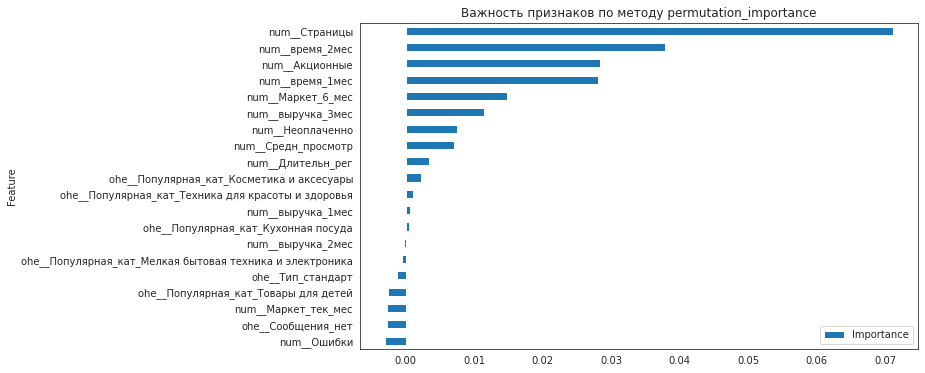

In [62]:
# Анализ permutation_importance

def custom_roc(model, X, y):
    y_pred = model.predict(X)
    score = roc_auc_score(y, y_pred)
    return score

# Придется вытащить модель из пайплайна, по другому не срабатывает...
model = best_models[1][1]
model.fit(X_train_p, y_train)

result = permutation_importance(model, X_test_p, y_test, scoring=custom_roc, random_state=RANDOM_STATE)

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Важность признаков по методу permutation_importance')

permutation_importance - показывает, насколько изменятся метрики, если поочерёдно рандомизировать каждый входной признак модели.

В нашем случае наибольшая важность у признаков: Страницы, Время, Акционные, Неоплачено, Маркетинг_6мес.

Наименьшая важность: Выручка, Тип подписки, Популярная категория, Длительность регистрации, Ошибки, Сообщения.

In [63]:
# анализ SHAP - график общей значимости признаков (ждем 2 мин.)

# Создание объекта KernelExplainer с вероятностями для одного класса
model = best_models[1][1]  # наша чистая модель из пайплайна
model.fit(X_train_p.values, y_train)  # без этого лезут ошибки

explainer = shap.KernelExplainer(lambda x: model.predict_proba(x), shap.sample(X_train_p, 10))

# Рассчет SHAP значений для тестовых данных
shap_values = explainer(shap.sample(X_test_p, 10))

  0%|          | 0/10 [00:00<?, ?it/s]

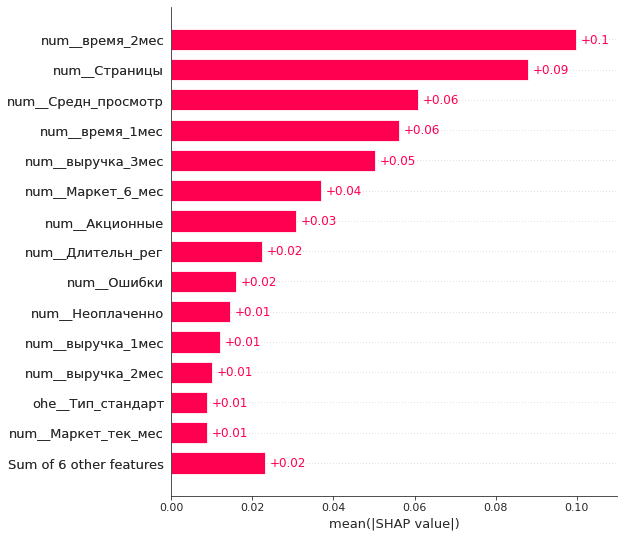

In [64]:
# Визуализация
shap.plots.bar(shap_values[:,:,1], max_display=15)

Видим, что к значимым признакам добавилась Выручка_3м и Средний просмотр.

In [65]:
# SHAP - другой график (ждем 2 мин.)

m = SVC(random_state=RANDOM_STATE, probability=True)
m.fit(X_train_p, y_train)

explainer = shap.KernelExplainer(m.predict_proba, shap.sample(X_test_p, 10))
shap_values = explainer.shap_values(shap.sample(X_test_p, 10))
#shap.plots.bar(shap_values[0])

  0%|          | 0/10 [00:00<?, ?it/s]

In [66]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test_p)

**Выводы по важности признаков:**

permutation_importance:
 - Наибольшая важность у признаков: Страницы, Время, Акционные, Неоплачено, Маркетинг_6мес.
 - Наименьшая важность: Выручка, Тип подписки, Популярная категория, Длительность регистрации, Ошибки, Сообщения.
 
SHAP:
 - Наибольшая важность: Страницы, Время, Выручка_3, Средний просмотр.
 - Наименьшая важность: Выручка_1 и_2, Популярная категория, Длительность регистрации, Ошибки, Сообщения. 

В целом это ровно то, что имело высокую корреляцию с Активностю ([корреляция](#corr)).

Бизнесу важно понимать, как «рассуждает» модель, чтобы грамотно рассчитывать последствия от её внедрения.
Оценка важности признаков в нашем случае показала: 
 - Наибольший вклад в Активность вносит группа показателей Поведения на сайте (Страницы, время_1мес и время_2мес) и Продуктовое поведение (Средний просмотр и Неоплаченные товары). 
 - Маркетинг имеет очень умеренное влияние на Активность (это хороший сигнал - можно уволить половину бездельников!? А по существу, коммуникация с клиентом - не работает).
 - Выручка имеет не однозначную связь с Активностью (нужна ли бизнесу Активность пользователей без Выручки, хм? Сделали красивые картинки - пользователи сидят на сайте и долго выбирают, а покупать идут к конкуренту... Возможно в компании стоит пресмотреть бизнес-метрики). 

При моделировании, на основе важности признаков можно провести Feature Selection и обучить модель на сокращенном наборе признаков - возможно качество улучшится.

## Сегментация покупателей и предложения

In [69]:
# Нам нужны прогнозные вероятности снижения активности

probas = best_models[1].predict_proba(df.drop('Активность', axis=1))
probas.shape

(1296, 2)

In [70]:
le.classes_

array(['Прежний уровень', 'Снизилась'], dtype=object)

In [71]:
# Готовим сводный датасет для анализа

df_segm = df.copy()

df_segm['Вер_снижения'] = probas[:,1]
df_segm = df_segm.merge(df4, on='id')

df_segm.head(3)

,id,Активность,Тип,Сообщения,Маркет_6_мес,Маркет_тек_мес,Длительн_рег,Акционные,Популярная_кат,Средн_просмотр,Неоплаченно,Ошибки,Страницы,выручка_2мес,выручка_3мес,выручка_1мес,время_2мес,время_1мес,Вер_снижения,Прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,0.866667,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,0.333333,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,0.800000,4.87


### Бизнес - это прибыль. 
Выберем для исследования сегмент с высокой прибылью.

In [72]:
#df_segm['Прибыль'].mean()
segm = df_segm.query('Прибыль > 4.8')

display(segm.shape[0])
segm.shape[0] / df.shape[0]

275

0.21219135802469136

20% клиентов приносят прибыль выше среднего.

In [73]:
# Отберем высокий риск снижения активности в прибыльном сегменте

segm['risk'] = np.where(segm['Вер_снижения']>0.7, 1, 0)

/tmp/ipykernel_620/3659452718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segm['risk'] = np.where(segm['Вер_снижения']>0.7, 1, 0)


<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

In [74]:
print(f'Доля клиентов в прибыльном сегменте с высоким риском снижения активности: {segm["risk"].mean():.2f}')

Доля клиентов в прибыльном сегменте с высоким риском снижения активности: 0.24


Text(0.5, 1.0, 'Вероятность снижения активности в прибыльном сегменте')

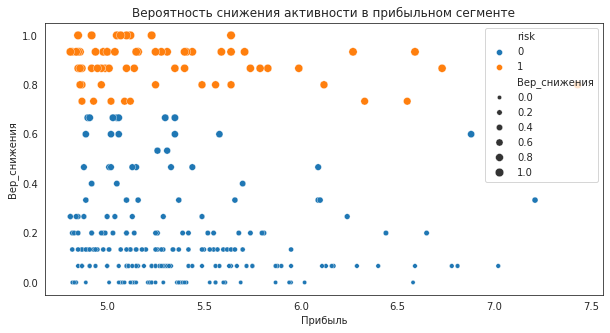

In [75]:
# Посмотрим, кто собирается снижать активность

plt.figure(figsize=(10,5))
sns.scatterplot(data=segm, y='Вер_снижения', x='Прибыль', hue='risk', size='Вер_снижения')
plt.title('Вероятность снижения активности в прибыльном сегменте')

На графике есть 2 четкие группы: кто очень вероятно снизит активность и кто не собирается снижать. Разберемся, что отличает эти полярные группы. 

Как мы установили при моделировании, есть несколько важных признаков отличающих клиентов по активности - последовательно рассмотрим их: Страницы, время_1мес, выручка_3мес, Средн_просмотр.
Добавим еще: Акционные, Маркет_6_мес, Маркет_тек_мес, Тип.

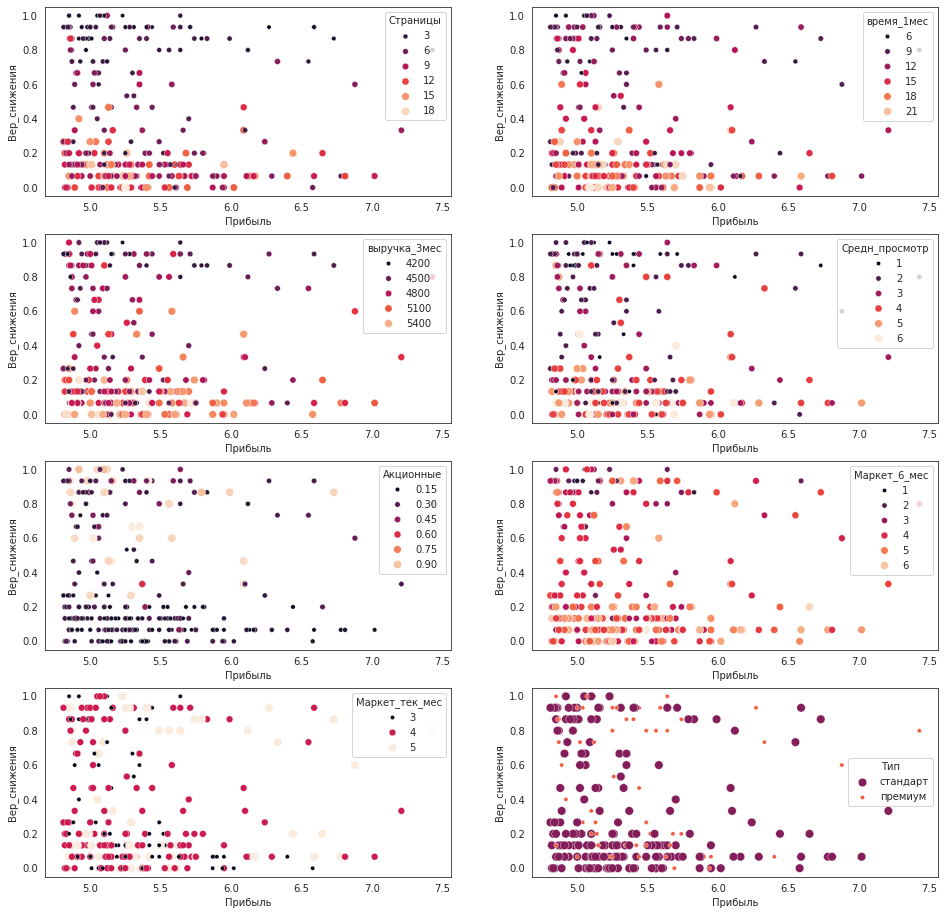

In [76]:
# Обзор значимых признаков применительно к нашему сегменту

features = ['Страницы', 'время_1мес', 'выручка_3мес', 'Средн_просмотр', 
            'Акционные', 'Маркет_6_мес', 'Маркет_тек_мес', 'Тип']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
for idx, feat in enumerate(features):
    sns.scatterplot(data=segm, y='Вер_снижения', x='Прибыль', hue=feat, 
                    size=feat, ax=axes[idx // 2, idx % 2], palette='rocket')    

### **Выводы и предложения по работе с сегментом прибыльных клиентов:**

Итак, в зоне риска 20% клиентов из прибыльного сегмента.

1. **Самое важное:** маркетинговая политика - не работает, а если и работает, то не там где нужно. Рекомендуется полностью пересмотреть подход (без увольнений не обойтись!). Ни 6 месячные действия, ни текущие, ни премиальная подписка - не приносят плодов.
2. В зоне риска немного выше доля халявщиков (чаще **покупают по акции**) - обратить внимание и заинтересовать персональными предложениями, пересмотреть рекомендации для данной группы.
3. Среднее **кол-во просмотренных категорий** для рисковой зоны - гораздо ниже чем у лояльных клиентов (1-2 против 4-5): необходимо выяснить какие категории могут быть интересны прибыльному сегменту, возможно система рекомендаций не справляется (то же уволить ответственного!). Подготовить предложения и провести А/В тестирования. Возможно добавить в магазин новые категории после соотвествующего расчета.
4. Хотя компания зарабатывает прибыль в данном сегменте, но с **выручкой** для клиентов с риском снижения активности - все плохо. За изученный период, зона риска отстает по выручке от лояльной группы - это следствие провальной маркетинговой политики, низкого интереса к категориям.
5. **Кол-во просмотренных страниц и время проведенное на сайте**: в общем 20% клиентов просто скучает на сайте (всего пара страниц и клиент уходит)! Возможно ассортимент не досточно богат, возможно дизайн сайта сложен/неудобен/непонятен/... (вот и дизайнера - уволим!).
6. Критерием оценки дальнейших действий может стать: кол-во страниц, время и выручка.

**Таким образом**, наша модель не только спрогнозировала снижение активности, но и помогла выявить целый ряд слабых точек в бизнес-модели, а так же группу нерадивых сотрудников-лентяев.

## Общий вывод

**Задача проекта:**

1.	Разработать модель, которая предскажет вероятность снижения покупательской активности.
2.	Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность. 

**Описание источников данных:**

1. данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. данные о выручке, которую получает магазин с покупателя за период.
3. данные о времени, которое покупатель провёл на сайте в течение периода.
4. данные о среднемесячной прибыли.

При подготовке данных устранены опечатки, выявлен дисбаланс категорий, выявлен один выброс, отобраны клиенты с активностью за 3 месяца. Перед моделированием числовые столбцы были масштабированы (способ выбран через оптимизацию), категориальные столбцы кодированы в числа (способ выбран в цикле).

**Выбор модели машинного обучения:**
1. Сделан базовый прогноз по 4 моделям (KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC()).
2. На основе подбора гиперпараметров (метод RandomizedSearchCV) подбиралась модель по лучшей метрике ROC_AUC.
3. На основании оценки лучшая модель: базовая SVC(random_state=RANDOM_STATE, probability=True), на данных кодированых StandardScaler + OHE.

**Сегментация покупателей и рекомендации:**

Моделью SHAP были отобраны наиболее значимые признаки, на их основе проведена оценка наиболее прибыльного сегмента.

Установлено, что в зоне риска 20% клиентов из прибыльного сегмента.

1. **Самое важное:** маркетинговая политика - не работает, а если и работает, то не там где нужно. Рекомендуется полностью пересмотреть подход. Ни 6 месячные действия, ни текущие, ни премиальная подписка - не приносят плодов.
2. В зоне риска немного выше доля халявщиков (чаще **покупают по акции**) - обратить внимание и заинтересовать персональными предложениями, пересмотреть рекомендации для данной группы.
3. Среднее **кол-во просмотренных категорий** для рисковой зоны - гораздо ниже чем у лояльных клиентов (1-2 против 4-5): необходимо выяснить какие категории могут быть интересны прибыльному сегменту, возможно система рекомендаций не справляется. Подготовить предложения и провести А/В тестирования. Возможно добавить в магазин новые категории после соотвествующего расчета.
4. Хотя компания зарабатывает прибыль в данном сегменте, но с **выручкой** для клиентов с риском снижения активности - все плохо. За изученный период, зона риска отстает по выручке от лояльной группы - это следствие провальной маркетинговой политики, низкого интереса к категориям.
5. **Кол-во просмотренных страниц и время проведенное на сайте**: в общем 20% клиентов просто скучает на сайте (всего пара страниц и клиент уходит)! Возможно ассортимент не досточно богат, возможно дизайн сайта сложен/неудобен/непонятен/...
6. Критерием оценки дальнейших действий может стать: кол-во страниц, время и выручка.